# AB testing - 게임 Cookie Cats 데이터 활용

### 목차
1. 프로젝트 목적
2. 데이터 설명
3. 사용자 특징 분석
4. 리텐션 분석(1-day, 7-day)
5. 정리

## 1. 프로젝트 목적
- Cookie Cat 게임의 리텐션에 레벨 디자인이 어떤 영향을 주는지 분석해보기 위한 프로젝트
- 해당 게임은 플레이하다보면 인앱 구매를 해야하는 상황이 생긴다. 이 인앱 구매 설정을 어떤 단계에서 하는게 좋을지 확인해보고자 진행한 프로젝트이다.

## 2. 데이터 설명
- userid: 유저 ID.
- version: 해당 유저 각각의 인앱 구매가 요구되는 레벨. (gate_30: 레벨 30의 게이트, gate_40: 레벨 40의 게이트)
- sum_gamerounds: 게임 설치 후 첫 주 동안 플레이어가 플레이한 게임 라운드 수.
- retention_1: 설치 한 뒤 1일 후에 게임을 플레이하였는지.
- retention_7: 설치 한 뒤 7일 후에 게임을 플레이하였는지.

### * 플레이어는 게임을 설치하고 gate 30과 gate 40중 하나를 랜덤하게 배정 받고 시작합니다.

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("C:/Users/dhckd/Study/CodingWorld/PP_datasets/cookie_cats/cookie_cats.csv")

In [3]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
df.userid.count()

90189

In [5]:
# 유저 중복 확인
print(df.userid.nunique() == df.shape[0])
# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [6]:
# 두 그룹으로 나누기
# 먼저 표본 수가 비슷한지 확인
df.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


- gate_30 그룹은 44700, gate_40 그룹은 45489

#### A, B그룹으로 나누기

In [7]:
condition_A = (df['version'] == 'gate_30')
condition_B = (df['version'] == 'gate_40')

In [8]:
df_A = df[condition_A]
df_B = df[condition_B]

In [9]:
df_A

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False
...,...,...,...,...,...
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False


#### 라운드 수에 따른 유저 수 분포

### 생각해볼 요소
- sum_gameround가 30, 혹은 40 이상일 때 유의미하다는 것. 
- 만약 version이 gate_30인 유저가 있다면, 인앱구매에 노출되기 위해선 gate_30까지 클리어하기 위한 최소 플레이 수인 30 이상을 만족해야한다. 하지만 sum_gameround가 5라면, 이 유저는 인앱 구매에 노출된 적이 없기 때문에 허수라고 판단하고 제거하였다.

In [10]:
# gate_30 그룹
# 30 이상인 표본만 df_A2에 새로 저장
condition_A2 = (df_A['sum_gamerounds'] >= 30)
df_A2 = df_A[condition_A2]

In [11]:
df_A2

,userid,version,sum_gamerounds,retention_1,retention_7
1,337,gate_30,38,True,False
13,2179,gate_30,39,True,False
14,2218,gate_30,305,True,True
15,2382,gate_30,73,True,False
17,2451,gate_30,204,True,True
...,...,...,...,...,...
90163,9996688,gate_30,83,True,True
90164,9996750,gate_30,48,True,False
90165,9996935,gate_30,35,False,True
90171,9997757,gate_30,84,True,False


In [12]:
# gate_40 그룹
# 40 이상인 표본만 df_B2에 새로 저장
condition_B2 = (df_B['sum_gamerounds'] >= 40)
df_B2 = df_B[condition_B2]

In [13]:
df_B2

,userid,version,sum_gamerounds,retention_1,retention_7
2,377,gate_40,165,True,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False
...,...,...,...,...,...
90159,9996209,gate_40,40,True,False
90167,9997037,gate_40,44,False,False
90177,9998376,gate_40,53,False,False
90184,9999441,gate_40,97,True,False


In [14]:
df_A2.sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

count     16656.000000
median       72.000000
mean        125.078470
std         410.314402
max       49854.000000
Name: sum_gamerounds, dtype: float64

In [15]:
df_B2.sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

count     13827.000000
median       92.000000
mean        142.667824
std         151.198353
max        2640.000000
Name: sum_gamerounds, dtype: float64

### 그룹 A와 그룹 B의 분포 살펴보기(sum_gamerounds)

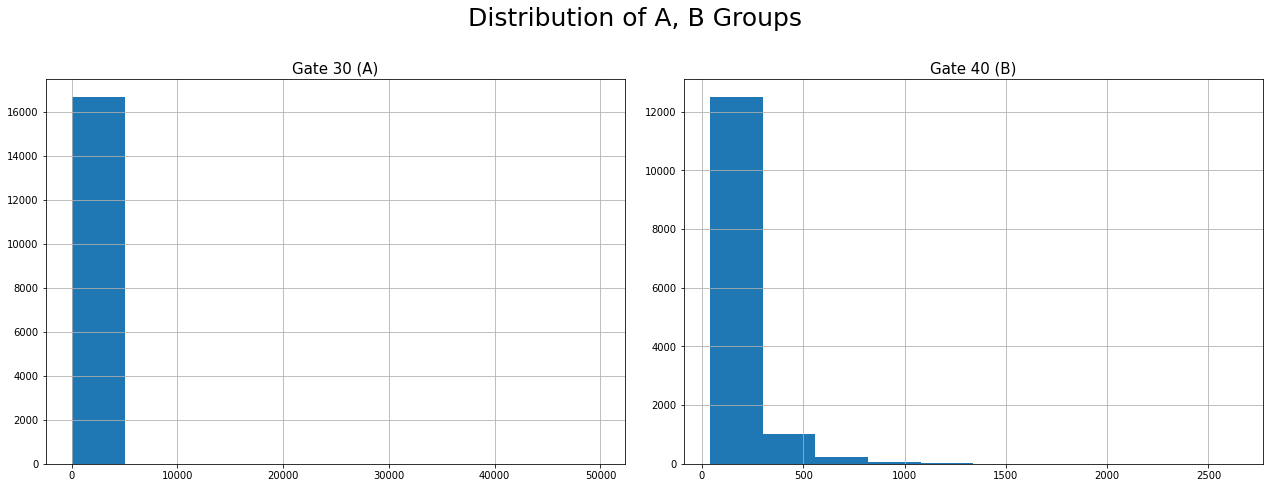

In [16]:
# 히스토그램
fig, axes = plt.subplots(1, 2, figsize = (18,7))
df_A2.hist('sum_gamerounds', ax = axes[0])
df_B2.hist('sum_gamerounds', ax = axes[1])


# title설정
plt.suptitle("Distribution of A, B Groups", fontsize = 25)
axes[0].set_title("Gate 30 (A)", fontsize = 15)
axes[1].set_title("Gate 40 (B)", fontsize = 15)

plt.tight_layout(pad = 2);

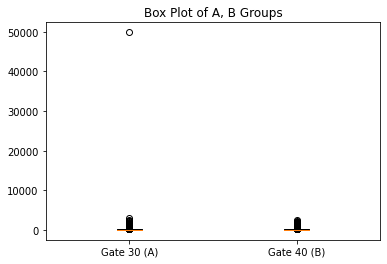

In [17]:
# boxplot
fig, ax = plt.subplots()
ax.boxplot([df_A2['sum_gamerounds'], df_B2['sum_gamerounds']])
plt.title('Box Plot of A, B Groups')
plt.xticks([1, 2], ['Gate 30 (A)', 'Gate 40 (B)'])
plt.show()

#### box plot을 통해 강한 이상치를 보이는 데이터 확인
- A에만 높은 이상치 하나가 있는 것처럼 보임
- (일단 99.7%를 기준(3 standard deviation)으로 이상치를 판단하고 제거) X

### 이상값 제거
- 만약 이상값들이 같은 특징으로 그룹을 짓는 모습을 보인다면, 충분히 분석하고 이상치그룹으로 다룰 것인지, 삭제할 것인지 정해야한다. 하지만 여기서 판단할 수 있는 지표는 리텐션1, 7 뿐, 특정 클래스로 나뉘는 모습을 볼 수 있는 부분은 Gate30과 Gate40 뿐이다. 그렇기에 삭제를 진행하자.

- A 그룹의 이상치 제거
- 제일 큰 값을 지워보자

In [18]:
max(df_A2.sum_gamerounds)

49854

In [19]:
# A그룹 최대값 삭제
df_A2 = df_A2[df_A2.sum_gamerounds != max(df_A2.sum_gamerounds)]

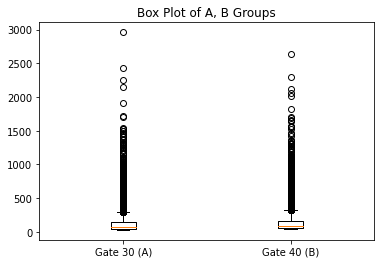

In [20]:
# boxplot
fig, ax = plt.subplots()
ax.boxplot([df_A2['sum_gamerounds'], df_B2['sum_gamerounds']])
plt.title('Box Plot of A, B Groups')
plt.xticks([1, 2], ['Gate 30 (A)', 'Gate 40 (B)'])
plt.show()

### 이상치 판단 기준 중 IQR방식 활용

In [21]:
def delete_outlier(df, column, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25) # 25%
    quantile_75 = np.percentile(df[column].values, 75) # 75%
    
    # IQR 식
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    # Q1-1.5*IQR보다 작거나 Q3+1.5*IQR보다 큰 데이터를 이상값으로 판단
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [22]:
A_outliers_index = delete_outlier(df = df_A2, column = 'sum_gamerounds')
df_A2_out = df_A2.drop(A_outliers_index, axis = 0)

In [23]:
B_outliers_index = delete_outlier(df = df_B2, column = 'sum_gamerounds')
df_B2_out = df_B2.drop(B_outliers_index, axis = 0)

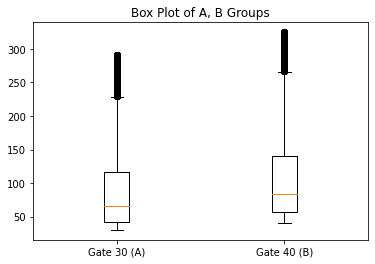

In [24]:
# boxplot
fig, ax = plt.subplots()
ax.boxplot([df_A2_out['sum_gamerounds'], df_B2_out['sum_gamerounds']])
plt.title('Box Plot of A, B Groups')
plt.xticks([1, 2], ['Gate 30 (A)', 'Gate 40 (B)'])
plt.show()

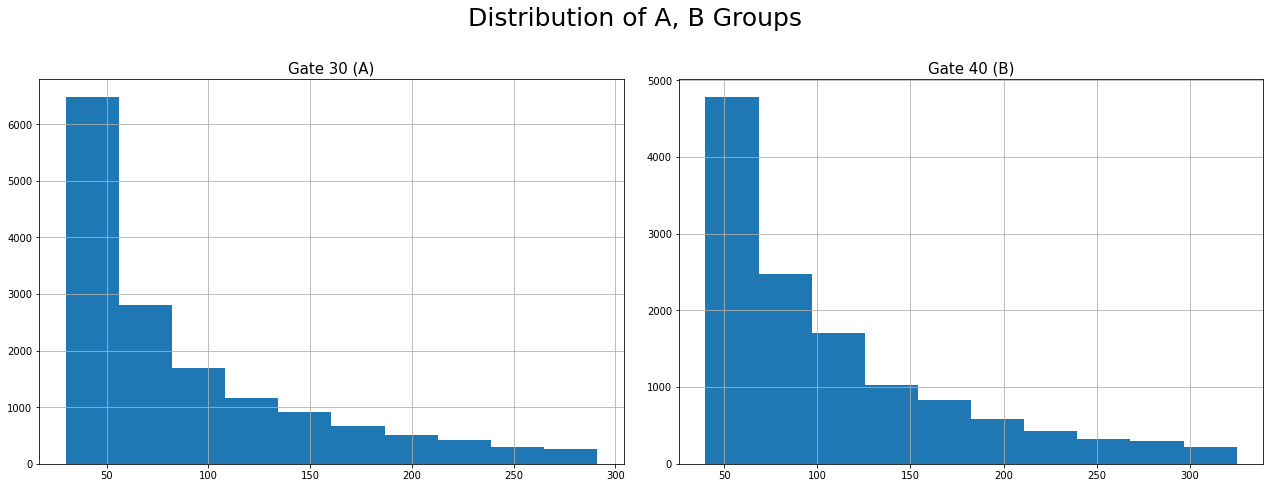

In [25]:
# 히스토그램
fig, axes = plt.subplots(1, 2, figsize = (18,7))
df_A2_out.hist('sum_gamerounds', ax = axes[0])
df_B2_out.hist('sum_gamerounds', ax = axes[1])


# title설정
plt.suptitle("Distribution of A, B Groups", fontsize = 25)
axes[0].set_title("Gate 30 (A)", fontsize = 15)
axes[1].set_title("Gate 40 (B)", fontsize = 15)

plt.tight_layout(pad = 2)

### skew 된 그래프?
- 이게 문제일까?
- 게임 특성이 레벨 하나씩 깨면서 올라가는 것이니 당연한 구조일 것이다.
- 모집단이 특정확률분포(정규분포 등)을 따르지 않는 것으로 판단되니 chi2 테스트 사용해야할 것.

## 리텐션 분석(1-day, 7-day)
- 결국 리텐션이 7까지 유지되는지 알고싶은게 분석의 포인트
- 그렇다면 retention_7이 True인 경우를 1로 두고 아닌 경우를 0으로 둬서 표현할 것.
- retention_1이 False지만 retention_7이 True인 경우도 있다. 참고해야함.

In [66]:
df_A2_out['total_retention'] = list(map(lambda x, y: str(x) + str(y), df_A2_out.retention_1, df_A2_out.retention_7))

In [68]:
df_B2_out['total_retention'] = list(map(lambda x, y: str(x) + str(y), df_B2_out.retention_1, df_B2_out.retention_7))

In [69]:
df_A2_out

,userid,version,sum_gamerounds,retention_1,retention_7,total_retention
1,337,gate_30,38,True,False,TrueFalse
13,2179,gate_30,39,True,False,TrueFalse
15,2382,gate_30,73,True,False,TrueFalse
17,2451,gate_30,204,True,True,TrueTrue
18,2482,gate_30,108,True,True,TrueTrue
...,...,...,...,...,...,...
90163,9996688,gate_30,83,True,True,TrueTrue
90164,9996750,gate_30,48,True,False,TrueFalse
90165,9996935,gate_30,35,False,True,FalseTrue
90171,9997757,gate_30,84,True,False,TrueFalse


In [70]:
df_B2_out

,userid,version,sum_gamerounds,retention_1,retention_7,total_retention
2,377,gate_40,165,True,False,TrueFalse
4,488,gate_40,179,True,True,TrueTrue
5,540,gate_40,187,True,True,TrueTrue
8,1574,gate_40,108,True,True,TrueTrue
9,1587,gate_40,153,True,False,TrueFalse
...,...,...,...,...,...,...
90159,9996209,gate_40,40,True,False,TrueFalse
90167,9997037,gate_40,44,False,False,FalseFalse
90177,9998376,gate_40,53,False,False,FalseFalse
90184,9999441,gate_40,97,True,False,TrueFalse


### 이제 total_retention의 평균을 구한 뒤, 두 그룹의 평균 차이가 유의미한 차이인지 T test를 통해 확인

In [80]:
total_retention_rate = []
for i in df_A2_out['total_retention']:
    if i == 'TrueTrue':
        total_retention_rate.append(1)
    else:
        total_retention_rate.append(0)

df_A2_out['total_retention_rate'] = total_retention_rate

In [81]:
df_A2_out

,userid,version,sum_gamerounds,retention_1,retention_7,total_retention,total_retention_rate
1,337,gate_30,38,True,False,TrueFalse,0
13,2179,gate_30,39,True,False,TrueFalse,0
15,2382,gate_30,73,True,False,TrueFalse,0
17,2451,gate_30,204,True,True,TrueTrue,1
18,2482,gate_30,108,True,True,TrueTrue,1
...,...,...,...,...,...,...,...
90163,9996688,gate_30,83,True,True,TrueTrue,1
90164,9996750,gate_30,48,True,False,TrueFalse,0
90165,9996935,gate_30,35,False,True,FalseTrue,0
90171,9997757,gate_30,84,True,False,TrueFalse,0


In [82]:
total_retention_rate = []
for i in df_B2_out['total_retention']:
    if i == 'TrueTrue':
        total_retention_rate.append(1)
    else:
        total_retention_rate.append(0)

df_B2_out['total_retention_rate'] = total_retention_rate

In [83]:
df_B2_out

,userid,version,sum_gamerounds,retention_1,retention_7,total_retention,total_retention_rate
2,377,gate_40,165,True,False,TrueFalse,0
4,488,gate_40,179,True,True,TrueTrue,1
5,540,gate_40,187,True,True,TrueTrue,1
8,1574,gate_40,108,True,True,TrueTrue,1
9,1587,gate_40,153,True,False,TrueFalse,0
...,...,...,...,...,...,...,...
90159,9996209,gate_40,40,True,False,TrueFalse,0
90167,9997037,gate_40,44,False,False,FalseFalse,0
90177,9998376,gate_40,53,False,False,FalseFalse,0
90184,9999441,gate_40,97,True,False,TrueFalse,0


## 5. AB test (t test 활용)
- A그룹과 B그룹의 전환율 비교

In [91]:
# 평균적으로 retention이 7일까지 전환되는 비율
avg_A = sum(df_A2_out['total_retention_rate'])/len(df_A2_out['total_retention_rate'])
avg_B = sum(df_B2_out['total_retention_rate'])/len(df_B2_out['total_retention_rate'])

In [93]:
print('A그룹의 전환율: ', avg_A)
print('B그룹의 평균: ', avg_B)

A그룹의 평균:  0.3233072831155185
B그룹의 평균:  0.37298021596910225


#### 여기서의 5% 차이가 유의미한 차이일까?

In [84]:
# 데이터 담기
rate_A = df_A2_out['total_retention_rate']
rate_B = df_B2_out['total_retention_rate']

In [89]:
# 검정 코드 (t-test)
stats.ttest_ind(rate_A, rate_B, equal_var = False)

Ttest_indResult(statistic=-8.672769554708939, pvalue=4.452836501198877e-18)

### p-value가 0.05보다 높기 때문에 gate_30과 gate_40의 차이는 유의미한 차이라고 볼 수 없다.